# Exercicio 2.4

# Exploratory Data Analysis (EDA)

### Exploração inicial das linhas e classes

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
pd.set_option('display.max_colwidth', None)

train_df = pd.read_csv('imdb_reviews_train.csv')
test_df = pd.read_csv('imdb_reviews_test.csv')

In [ ]:
print(train_df.shape)
print(test_df.shape)

(21754, 2)
(21996, 2)


In [ ]:
print(f"Conjunto de treino: {train_df.head()}\n")
print(f"\nConjunto de teste: {test_df.head()}")

Conjunto de treino:                                                           text label
0  This is your typical cheerful and colorful MGM musical f...   pos
1  As a another reviewer states Hanna's War is an outstandi...   pos
2  One of the best "Amitabh comeback" movies I liked. This ...   pos
3  Peter Sollett has created an endearing portrait about re...   pos
4  The film is not visually stunning in the conventional se...   pos


Conjunto de teste:                                                           text label
0  Logan Lerman & Dean Collins III of Jack & Bobby Fame pro...   pos
1  I have seen this film on a Sunday evening and I must say...   pos
2  Two great stars and a legendary Director created a magni...   pos
3  I'm originally from Brazil... the sad thing about this m...   pos
4  "Witchery" is a decent little Euro Trash horror yarn! Da...   pos


In [ ]:
print(train_df.describe())
print(test_df.describe())

                                                               text  label
count                                                         21754  21754
unique                                                        21662      2
top     How has this piece of crap stayed on TV this long? It's ...    neg
freq                                                              3  10978
                                                               text  label
count                                                         21996  21996
unique                                                        21814      2
top     Loved today's show!!! It was a variety and not solely co...    neg
freq                                                              5  11050


In [ ]:
# Tipo de dados nas colunas
print(train_df.dtypes)

text     object
label    object
dtype: object


In [ ]:
# Verificar os rótulos no conjunto de treino
print(train_df['label'].unique())

['pos' 'neg']


Como especificado no enunciado, os dados do iMDb têm apenas *reviews* classificadas com sentimento positivo ou negativo.

In [ ]:
# Verificação do número de linhas para cada rótulo
print(f"# de linhas por label, conjunto de treino: {train_df['label'].value_counts()}\n")
print(f"\n# de linhas por label, conjunto de teste: {test_df['label'].value_counts()}")

# de linhas por label, conjunto de treino: label
neg    10978
pos    10776
Name: count, dtype: int64


# de linhas por label, conjunto de teste: label
neg    11050
pos    10946
Name: count, dtype: int64


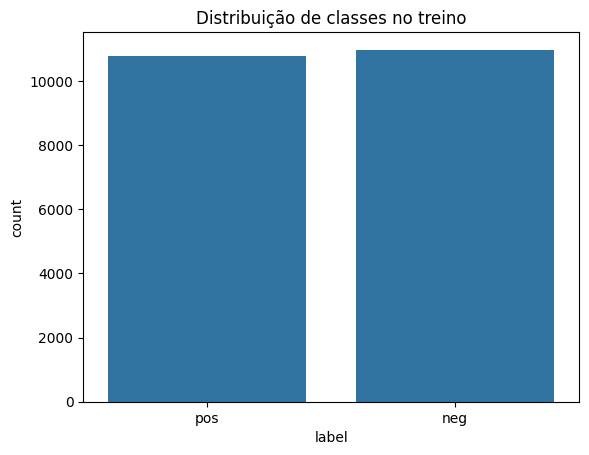

In [ ]:
sns.countplot(x='label', data=train_df)
plt.title("Distribuição de classes no treino")
plt.show()

Como a distribuição entre as classes está muito próxima de ser totalmente equilibrada, não achamos justificável fazer transformações para balancear os conjuntos, sendo que não deverá causar problemas durante o treino ou avaliação do modelo

In [ ]:
# Verificar duplicados em ambos conjuntos de dados
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())

92
182


Existem 92 e 182 linhas duplicadas para os conjuntos de treino e teste, respetivamente. Será necessário lidar com elas aquando da limpeza dos dados.

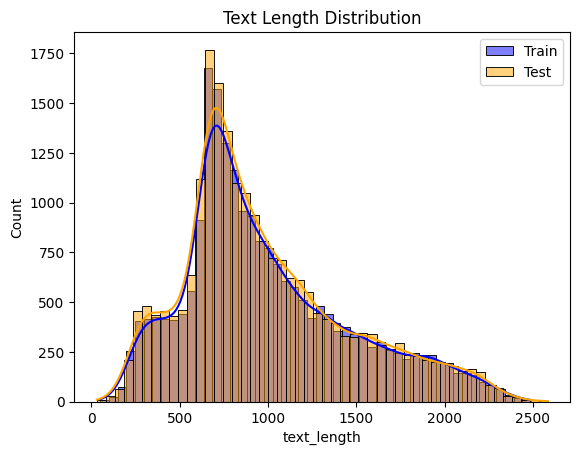

In [ ]:
# Estudo da distribuição do comprimento do texto
train_df['text_length'] = train_df['text'].apply(len)
test_df['text_length'] = test_df['text'].apply(len)

sns.histplot(train_df['text_length'], bins=50, kde=True, color='blue', label='Train')
sns.histplot(test_df['text_length'], bins=50, kde=True, color='orange', label='Test')
plt.legend()
plt.title("Text Length Distribution")
plt.show()

Através do plot conseguimos perceber que o treino e o teste têm comprimento de texto similares, o que é bom, porque o teste é representativo do treino em termos de comprimento de texto.
A maioria dos textos têm menos palavras, e há uma concentração maior de textos com menos 1000 palavras (~aproximadamente 700 palavras).

In [ ]:
# Verificação de valores nulos e empty strings
print(f"# de valores nulos idetificados no conjunto de treino: {train_df['text'].isnull().sum()}")
print(f"# de empty strings identificadas no conjunto de treino: {(train_df['text'].str.strip() == '').sum()}")

# de valores nulos indetificados no conjunto de treino: 0
# de empty strings identificadas no conjunto de treino: 0


In [ ]:
# Análise de word frequency
positive_words = ' '.join(train_df[train_df['label'] == 'pos']['text']).split()
negative_words = ' '.join(train_df[train_df['label'] == 'neg']['text']).split()

print(Counter(positive_words).most_common(10))  # Top 10 palavras na classe positiva
print(Counter(negative_words).most_common(10))  # Top 10 palavras na casse negativa

[('the', 94535), ('and', 55472), ('a', 52107), ('of', 47721), ('to', 40914), ('is', 36851), ('in', 28893), ('I', 25286), ('that', 20250), ('this', 19576)]
[('the', 94169), ('a', 52309), ('and', 47639), ('of', 45828), ('to', 45664), ('is', 33655), ('I', 28674), ('in', 26926), ('this', 23962), ('that', 22015)]


É expectável que as palavras mais frequentes sejam palavras fechadas, portanto essas palavras terão de ser removidas.

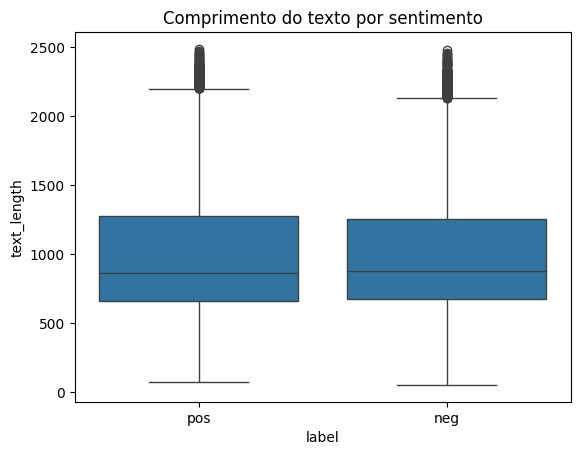

In [ ]:
sns.boxplot(x='label', y='text_length', data=train_df)
plt.title("Comprimento do texto por sentimento")
plt.show()

In [ ]:
train_df = train_df.drop(columns=['text_length'])
test_df = test_df.drop(columns=['text_length'])

print(train_df.describe())
print(test_df.describe())

                                                     text  label
count                                               21754  21754
unique                                              21662      2
top     How has this piece of crap stayed on TV this l...    neg
freq                                                    3  10978
                                                     text  label
count                                               21996  21996
unique                                              21814      2
top     Loved today's show!!! It was a variety and not...    neg
freq                                                    5  11050


Como observado, as reviews negativas têm um comprimento um pouco maior, o que faz sentido, porque as pessoas tendem a escrever mais para justificar a sua opinião negativa

***
Embora estudar o conjunto de teste seja também importante (usado para os Exercícios 2.2 e 2.3 do Trabalho), de forma a evitar o *Data Leakage*, a partir deste momento iremos estudar apenas o conjunto de treino. Os próximos passos são mais específicos e irão guiar as decisões sobre as técnicas de limpeza de texto a aplicar.


### Considerações Específicas sobre as Reviews

Tendo em conta que estamos a trabalhar com reviews de utilizadores do iMDb, é expectável encontrar:
- Comentários mal escritos, com erros ortográficos e gramaticais.
- Uso irregular de pontuação.
- Presença de hashtags, emojis, menções e gírias.
- Variações na capitalização de palavras (maiúsculas e minúsculas misturadas).

Além disso, o próprio processo de exportação dos dados - seja via web scraping ou API - pode introduzir:
- Caracteres especiais inesperados.
- Espaços extra ou desalinhados.
- Elementos HTML residuais.
- Codificações incorretas de texto.

Por estes motivos, a exploração a seguir será mais minuciosa e focada no texto do conjunto de treino.


#### Observações sobre HTML Tags

In [ ]:
# Ver casos de HTML tags nos dados
pattern_html_remanescente = re.compile(r"<[^>]+>")
linhas_html_remanescente = train_df[train_df["text"].str.contains(pattern_html_remanescente)]
display(linhas_html_remanescente.head())

,text,label
977,"> Contrary to most reviews I've read, I didn't...",pos
2134,An occasionally surrealistic thriller that wil...,pos
5957,"Contains spoilers ""Hollow Man"" is probably the...",pos
14871,"Once I ignored some of the implausibilities, ...",neg
15043,Remember the chain smoking channeler exposed o...,neg


> Durante a análise inicial dos dados, observou-se a presença de diversas **tags HTML** no texto das reviews.  
Além das tags normais, foram encontrados casos atípicos como `< i>` e `< e>`, que fogem aos padrões tradicionais de HTML e que também necessitam de ser removidos.

> Apesar disso, aplicar uma regra geral para eliminar qualquer conteúdo entre sinais de `< >` poderia trazer problemas. Exemplos reais encontrados incluem:
- `<sp>) classic "Romeo & Juliet". Guess I'll have to rent that next. >`
- `<SPOILER>`

> Nesses casos, a limpeza automática poderia remover partes relevantes do texto (como indicações de spoiler ou comentários relevantes), o que não seria o ideal. Portanto, a abordagem de limpeza deverá ser mais cuidadosa e seletiva, para garantir que apenas tags indesejadas ou inválidas sejam removidas.

#### Observações sobre links

##### Links com "http"

In [ ]:
# Palavras que contêm http
regex_http_cases = re.compile(r"http:", re.IGNORECASE)
linhas_suspeitas_http = train_df[train_df["text"].str.contains(regex_http_cases)]
display(linhas_suspeitas_http.head())
print(f"# total de linhas contendo http: {linhas_suspeitas_http.shape[0]}")

,text,label
36,"The person who wrote the review ""enough with the sweating and spitting already"" has no grasp of what cultural, literary, or psycho critique is. He dismisses Zizek's interpretations because they don't seem ""in line"" with what the director originally intended. So What? The importance of a director's (or author's) intention is not important in critical theory. This is known as the author's ""Intentional Fallacy"" and should be avoided. http: en.wikipedia.org wiki Intentional_fallacy A text or movie CAN be analyzed through a number of theories, many of which disagree with one another, as well as completely ignore the author's intention. This is the most fundamental idea of Critical Theory. Because of this, whoever wrote that wall of text wasted a lot of time and effort on insulting Zizek. In reality, anyone who studies theory would immediately discredit this guys opinion (I suggest you should too) as it is completely off point. That being said... If you are at all interested in Freudian, Laconian, or Kristevian discourse, this movie is a must. It connects these theories with popular film, making them much more palpable and enjoyable than simply reading or thinking about them.",pos
231,"Airwolf The Movie, A variation on the original 2 part pilot, Yet the movie although shorter, does contain extra footage Unseen in the 2 hour pilot The pilot is much more of a pilot than the movie Where as a pilot movie is normally the same (2 parter combined) But the movie is actually a different edit with extras here and cuts there. Worth a look, even if you have the season 1 DVD set, I'd still pick up a copy of the ""movie"" It's still in some shops like virgin, Woolworths and the likes of mixed media stores, although it generally needs ordering, But it saves needing to buy online (as many of us still don't do or trust online shopping) but if you look around airwolfs in stores Airwolf was truly 1 of the 80's most under rated shows. A full size Airwolf is currently being re built for a Helicopter Museum :) Info and work in progress pictures are over at http: Airwolf.org Also with Airwolf Mods for Flashpoint and Flight Sim Games It seams she's finally here to stay :)",pos
278,"Hi all I am a chess enthusiast since the age of about 6. I supposed I am quite obsessed by chess, but hopefully not as much as the central character in this film. In this film, the central character reflects a real chess player called Curt von Bardeleben who committed suicide in 1924. He is famous for a game he played against Steinitz, where a beautiful combination was played by Steinitz. Instead of resigning, he simply walked out of the tournament hall, never to return. The social ineptness of the central character is unfortunately a treat of some of the more serious Grandmasters you sometimes get in chess tournaments. Chess I suppose is a very big sacrifice, and you can sometimes end up imbalanced in other areas of life. A major example of this is the chess legend Bobby Fischer. Although a genius, he was also very disturbed in many ways. In the film, a World championship match is depicted, as between an Italian Grandmaster and Luzhin. The format is a knockout, which actually the world Governing body of Fide has sometimes employed as a format itself going from 128 players to just 2 in the final. But this was a group knockout which also depicts a realistic format, where the winners of each group play against each other. The position before adjournment makes for a fascinating chess puzzle in itself. In fact, I have done a youtube video about it, for you to explore the winning combination in detail enjoy! http: uk.youtube.com watch?v=XZPtdtPhwdM Best wishes Tryfon",pos
388,"I am so upset that ABC is giving up on yet another show that has the chance to be a real winner. This show is so good, the writing and storyline were great, an actual original idea for a show instead of another boring reality show. The casting was spectacular! Not only were the characters 

# total de linhas contendo http: 46


- Alguns links, como `http: Airwolf.org`, apresentam espaços (`\s`) logo após o `http:`, o que pode dificultar a remoção caso não seja considerada esta possibilidade.

In [ ]:
# Palavras que contêm http, seguido de um espaço
regex_http_cases = re.compile(r"http:\s", re.IGNORECASE)
linhas_suspeitas_http = train_df[train_df["text"].str.contains(regex_http_cases)]
linhas_suspeitas_http.head()

,text,label
36,"The person who wrote the review ""enough with the sweating and spitting already"" has no grasp of what cultural, literary, or psycho critique is. He dismisses Zizek's interpretations because they don't seem ""in line"" with what the director originally intended. So What? The importance of a director's (or author's) intention is not important in critical theory. This is known as the author's ""Intentional Fallacy"" and should be avoided. http: en.wikipedia.org wiki Intentional_fallacy A text or movie CAN be analyzed through a number of theories, many of which disagree with one another, as well as completely ignore the author's intention. This is the most fundamental idea of Critical Theory. Because of this, whoever wrote that wall of text wasted a lot of time and effort on insulting Zizek. In reality, anyone who studies theory would immediately discredit this guys opinion (I suggest you should too) as it is completely off point. That being said... If you are at all interested in Freudian, Laconian, or Kristevian discourse, this movie is a must. It connects these theories with popular film, making them much more palpable and enjoyable than simply reading or thinking about them.",pos
231,"Airwolf The Movie, A variation on the original 2 part pilot, Yet the movie although shorter, does contain extra footage Unseen in the 2 hour pilot The pilot is much more of a pilot than the movie Where as a pilot movie is normally the same (2 parter combined) But the movie is actually a different edit with extras here and cuts there. Worth a look, even if you have the season 1 DVD set, I'd still pick up a copy of the ""movie"" It's still in some shops like virgin, Woolworths and the likes of mixed media stores, although it generally needs ordering, But it saves needing to buy online (as many of us still don't do or trust online shopping) but if you look around airwolfs in stores Airwolf was truly 1 of the 80's most under rated shows. A full size Airwolf is currently being re built for a Helicopter Museum :) Info and work in progress pictures are over at http: Airwolf.org Also with Airwolf Mods for Flashpoint and Flight Sim Games It seams she's finally here to stay :)",pos
278,"Hi all I am a chess enthusiast since the age of about 6. I supposed I am quite obsessed by chess, but hopefully not as much as the central character in this film. In this film, the central character reflects a real chess player called Curt von Bardeleben who committed suicide in 1924. He is famous for a game he played against Steinitz, where a beautiful combination was played by Steinitz. Instead of resigning, he simply walked out of the tournament hall, never to return. The social ineptness of the central character is unfortunately a treat of some of the more serious Grandmasters you sometimes get in chess tournaments. Chess I suppose is a very big sacrifice, and you can sometimes end up imbalanced in other areas of life. A major example of this is the chess legend Bobby Fischer. Although a genius, he was also very disturbed in many ways. In the film, a World championship match is depicted, as between an Italian Grandmaster and Luzhin. The format is a knockout, which actually the world Governing body of Fide has sometimes employed as a format itself going from 128 players to just 2 in the final. But this was a group knockout which also depicts a realistic format, where the winners of each group play against each other. The position before adjournment makes for a fascinating chess puzzle in itself. In fact, I have done a youtube video about it, for you to explore the winning combination in detail enjoy! http: uk.youtube.com watch?v=XZPtdtPhwdM Best wishes Tryfon",pos
388,"I am so upset that ABC is giving up on yet another show that has the chance to be a real winner. This show is so good, the writing and storyline were great, an actual original idea for a show instead of another boring reality show. The casting was spectacular! Not only were the characters 

> Uma limpeza utilizando a expressão regular `http:\s*\S+` iria funcionar bem neste caso.  
Esta expressão regular captura qualquer ocorrência de `http:` seguida por um ou mais espaços (`\s*`) seguida de qualquer sequência de caracteres que não sejam espaços (`\S+`). Isto permite remover links mesmo quando existem espaços após o `http:`, como no caso de `http: Airwolf.org`.
***

##### Links com "www"

In [ ]:
# Palavras que contêm www
regex_www_cases = re.compile(r"\bwww\.", re.IGNORECASE)
linhas_suspeitas_www = train_df[train_df["text"].str.contains(regex_www_cases)]
display(linhas_suspeitas_www.head())
print(f"# total de linhas contendo www.: {linhas_suspeitas_www.shape[0]}")

,text,label
29,"I've watched it plenty of times and I'm planning on buying the full feature. I love all of Jason Steele's comedy. It's very different and unique and is very enjoyable. I love indie films and this one is just great. The plot is strange but very funny. This short film is about a talking Spatula named Edward. The order of the events are a bit jumbled, making this film very interesting to watch. At first you see Edward fighting the spoons, but then the focus changes to earlier in his life. This is a silly movie, but of course, it's still great. I highly recommend that you watch this film at www.spatulamadness.com or www.filmcow.com. It's very funny. The humour may not match everybody's taste but watch anyway. It'll only take 16 minutes of your time, and it's free. GO WATCH SPATULA MADNESS!",pos
248,"Credited by Variety to be one of the greatest documentaries to ever come out of Canada. Al Pacino, Roger Ebert, Neil Simon, Matt Dillon as well as a constant slew of celebs make this film a Canadian classic. The film is really best described as ""Roger & Me"" meets ""The Player"". Watch as Kenny Hotz and Spenny PITCH their script to the big boys of Hollywood. Called the only American film to ever come out of Canada, This film opened the Toronto Film Festival in 1997, Winner of the 'Best Indie Film Award Toronto'. Europe premier was at the prestigious HOF film fest in Germany. U.S.A. premier U.S. Comedy Festival Aspen 1999. More information available at www.kennyhotz.com",pos
388,"I am so upset that ABC is giving up on yet another show that has the chance to be a real winner. This show is so good, the writing and storyline were great, an actual original idea for a show instead of another boring reality show. The casting was spectacular! Not only were the characters and actors right on, but these are a very talented set of actors. The concept and idea is really a new and cool idea for a TV show, many of us share this whole idea of ""connections"". I really love the characters of Steven, Laura, Whitney and Damien. But to be honest there is not one person connected to this show that I did not like, even those that only were in for a few episodes (Sheri Appleby for example). The acting and characters are so easy to like and so talented!!. I wish ABC had given this show more of a chance, and not interrupted the show midway, Also it was not advertised enough. Truly unfair!! to everyone!!. This show showed great promise. I for one will let ABC know how I feel and will keep sending emails to keep this show alive. Please join me, I know we can do it. It worked for Jerico. (By the way where is episode 13? I want that last show!). Please support this show and send emails to ABC,we can do it!!! This show is well worth it!!! PETITION ONLINE TO SAVE SIX DEGREES: http: www.PetitionOnline.com gh1215 petition.html WE CAN DO IT!! SIGN THIS PETITION ASAP!!!",pos
423,"Currently on METOO's new schedule at 4 pm on weekdays, right after ""Maverick"" and right before ""Wild, Wild West"" (followed by ""Star Trek""). Don't know if I ever actually saw an episode of it when it was originally on, but I'm really captivated by it. Offbeat, unusual, surreal stories set in a mythical West. Kind of the ""Naked City"" of Westerns. And the guest stars are there: Dan Duryea, Lyle Bettger, Brian Donlevy, MacDonald Carey, Rick Jason (as a treacherous Mexican), a young Dick Van Patten, Jack Lord, Noah Berry, Jr. (as a colorful Mexican), Martha Hyer, Marguerite Chapman, even Ann Robinson (""War of the Worlds""), Gloria Talbott (""I Married a Monster from Outer Space"") It ran for EIGHT SEASONS, over 200 episodes, from January, 1959, to December, 1965. Eric Fleming is quite remarkable as trail boss Gil Favor, the most stolid man that's ever lived, with the code of honor of a Samurai, and just the right balance between toughness and open handedness. I would vote for him for President any day. (P.S. He had a very interesting biography: http: www.imdb.com name nm02

# total de linhas contendo www.: 50


- Existem casos onde a estrutura do link não está completamente unida, como em `www.imdb.com name nm0281661`.  
É importante notar que, com uma limpeza simples, apenas a parte `www.imdb.com` seria removida, enquanto o restante (`name nm0281661`) permaneceria no texto.

> Apesar de não terem sido encontrados no conjunto de treino, para garantir uma limpeza mais robusta, é importante considerar que palavras legítimas contendo sequências como `awwww` ou `wwwwwin` podem existir. Por isso, as expressões regulares foram construídas de forma cautelosa, evitando remoções indevidas.

> Neste contexto, expressões regulares como `\bwww\.\S+` funcionam bem para remover a parte principal dos links, capturando qualquer sequência de caracteres sem espaço (`\S+`) que comece imediatamente após `www.`.

### Observações sobre hashtags

In [ ]:
# Palavras que contêm hashtags
regex_hashtag_cases = re.compile(r"#\S+", re.IGNORECASE)
linhas_suspeitas_hashtags = train_df[train_df["text"].str.contains(regex_hashtag_cases)]
display(linhas_suspeitas_hashtags.head())
print(f"# total de linhas com hashtags: {linhas_suspeitas_hashtags.shape[0]}")

,text,label
90,"`Bruce Almighty' will sweep the Academy Awards with a record 14 Oscar wins! It will surpass `Titanic' as the highest grossing film of all time! Jim Carrey's illustriousness will be at such a supreme level that he will announce his presidential candidacy for the 2004 White House playoffs. Almighty then! These grandeur fantasies would only transpire if the filmmakers (Carrey included) would possess the powers of God. That very same premise is the paramount ingredient in Carrey's new laugh riot `Bruce Almighty'. Carrey plays Bruce Nolan, a televison reporter who is so utterly obsessed in being the main anchor that he holds God to total culpability for his own contretemps. God, heavenly played by Morgan Freeman, grants Bruce the `Gift of God'(his powers) in order to challenge him if he can do God's job any better. Obviously, Bruce gets `carreyed' away with his newfound blissful faculties and uses them selfishly. Carrey is back in his habitual almighty comedic form in `Bruce Almighty'. Jennifer Aniston was not `mis.pittiful' as Bruce's girlfriend. However, my premier kudos goes to Director Tom Shadyac for not letting the dog out of the house for #2, and showing us the most hilarious doggoned bathroom scene of all time! `Bruce Almighty' is not the most in depth Carrey film, but it is still an almighty chuckling exhibition of `Carreyism'! **** Good",pos
334,"This film is like marmite. You either love it or you hate it. If you go into this film expecting a proper film with decent production values, a good plot and great characters you'll hate it. If you go into this film expecting a low budget slasher you'll probably hate it. If you go into this film expecting to see one of the most deranged characters ever put to film in the form of Harry Russo you will love it. John Giancaspro is absolutely brilliant in his over the top portrayal of the insane, murderous coke fiend. The special effects are abysmal at best but really, who cares? If you're the kind of person who's prepared to watch a film Schizophreniac: The Whore Mangler you've undoubtedly seen scores of horror films filled with gore. With the budget this film was made for even if they had tried it probably would've mediocre at best. I'd much rather be able to laugh at something abysmal than be unaffected by the mediocre. To sum it up, you'll probably hate this film but if you're one of the few who decide to see it anyway it'll become the best thing since sliced bread #2 I hate marmite.",pos
509,"Kim Novak's a witch on the prowl for a mortal lover, and James Stewart's her choice. Scintillating comedy of manners, from the Broadway stage; shot by James Wong Howe in Witch Color, and performed by a sterling cast. Ernie Kovacs is wonderful as the perpetually dishevelled writer Redlitch. I love this movie, though few others seem to. Kim alone makes it a winner in my Book. Ha! My #5 film of 1958.",pos
760,"I heard a few friends one day saying that ""Scarface sucks... some idiot tried to make another Godfather set in the early 80s."" Now, I usualy listen to idiots watch CNN so I decided I'd stay away from it. Then my mate handed me the DVD and said ""This is #1 with the pelicangs"", confused I tried it. This IS THE BEST FILM EVER MADE. It's more realistic than all this crap about racing stolen cars that are too expensive for someone in that area could afford (*cough2Fast2Furiouscough*) There is some humor though... i.e. the Pelicangs and the light 80s music. Still, whats better than Al Pacino wielding an m203? I give this a ***** out of ****, perfect for fans of Al or GTA:Vice City.",pos
1108,"Very few movies have had the impact on American culture the way Urban Cowboy has. Thank god it was temporary. But UC is almost in a class by itself as one of those flicks that when you're flipping channels at 3:00AM you just can't take your eyes off....my top three are Animal House and Walking Tall BTW but that's beside the point. I remember Urban Cowboy hit the theaters and overnite th

# total de linhas com hashtags: 113


> Foram encontrados casos com palavras como `"Pack at S*#t!"` e também `"This is #1 with the pelicangs"`. Uma limpeza simples iria retirar o `#`, o que claramente afetaria palavras que têm um valor importante para o sentimento.

> A expressão regular `(?:^|\s)#([a-zA-Z]+)\b` funcionaria bem nestes casos. Garante que o # seja detectado apenas quando precedido por um espaço ou no início da frase. A parte `([a-zA-Z]+)` captura apenas palavras compostas por letras, assegurando que símbolos indesejados e números sejam ignorados.
***

## Exercício 2.6

> No exercício 2.6, exploramos as reviews dos *notebook-devel.csv* e *notebook-challenge.txt*, sendo o primeiro conjunto rotulado e o segundo não rotulado, respectivamente.

In [ ]:
# Leitura do notebook com labels, para estudo do melhor modelo
file_path_devel = "notebooks-train.csv"
df_devel = pd.read_csv(file_path_devel, sep='\t')

In [ ]:
# Leitura do notebook sem labels
file_path_challenge = "notebooks-challenge.txt"
with open(file_path_challenge, 'r', encoding='utf-8') as f:
    next(f)
    test_data = [line.strip() for line in f]
df_challenge = pd.DataFrame(test_data, columns=['review_text'])

In [ ]:
df_devel.head()

,sentiment,review_text
0,pos,Estou contente com a compra entrega rápida o único problema com as <empresa> é se houver troca ou devolução do produto o consumidor tem problemas com espera.
1,pos,"Excelente!!! Produto muito bom, bonito, design super moderno. De ótima qualidade! Gostei muito!"
2,pos,"Superou expectativas É excelente para jogos, super rápido tela full hd tamanho ideal leve e Pratico"
3,pos,"Comprei o mesmo para minha irmã e ela me contou que ele é ótimo, rápido e a imagem é muito bonita. Tive oportunidade de mexer com ele e realmente ele cumpre com o que disse. Recomendo demais para quem estuda ou trabalha com um. Obrigado a <empresa> e a Asus!"
4,pos,Notebbok muito bom! Rápido pequeno e leve para quem quer um notebook com um bom desempenho e que oculpa pouco espaço ele é perfeito. A autonomia da bateria é muito boa. Ele liga e desliga muito rápido.


In [ ]:
df_challenge.head()

,review_text
0,"O note é bom, mas não superou as expectativas quanto a velocidade, por isso sugiro 8GB"
1,"Ele corresponde ao valor pago. Custando em média R$ 2000, não encontraremos nada melhor."
2,"O notebook é muito bom, o Windows 10 ferra um pouco com a velocidade, mas isso é coisa do sistema operacional. Recomendo muito esse produto."
3,"O notebook tem uma tela enorme, muito útil para trabalhar e fazer trabalhos acadêmicos. É lindo..."
4,Muito bom ! Excelente notebook! Entrega rapida. Fiquei muito satisfeita.


> Ambos os conjuntos apresentam uma grande diversidade, incluindo tanto frases curtas quanto textos longos e detalhados, e exibem variações linguísticas típicas do português brasileiro, como uso informal, erros ortográficos e acentuação inconsistente (e.g., “Notebbok” em vez de “Notebook”). Além disso, é frequente a presença de caracteres especiais e pontuação excessiva (e.g., “Excelente!!!”).

> Ao comparar os textos de ambos os conjuntos, observa-se que, apesar de um ser rotulado e o outro não, as características linguísticas e de estrutura das reviews são muito semelhantes. Seria interessante testar uma ferramenta que seja capaz de trabalhar com idioma Português-Brasileiro.
